In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from astropy import units as u
from astropy.coordinates import SkyCoord, EarthLocation
from astropy.io import fits
from spectral_cube import SpectralCube
from spectral_cube import BooleanArrayMask
from astropy.convolution import Gaussian1DKernel, convolve
import aplpy  
from astropy.wcs import WCS
from reproject import reproject_interp
from astroquery.vizier import Vizier
from astroquery.skyview import SkyView
from astropy.time import Time

Vizier.ROW_LIMIT = -1

mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['font.size'] = '16'
mpl.rcParams['xtick.direction'] = 'in'
mpl.rcParams['ytick.direction'] = 'in'
%matplotlib inline


Bad key "text.kerning_factor" on line 4 in
/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.2/matplotlibrc.template
or from the matplotlib source distribution


In [2]:
cube = SpectralCube.read('/Users/denes/Research/high_lat_HI/ASKAP_data/data_cubes/Norma_MW.fits')  # Open the FITS file for reading


In [60]:
cube_2 = cube.with_spectral_unit(u.km/u.s, velocity_convention='optical', rest_value=1.420405752 * u.GHz) 
subcube = cube_2.spectral_slab(400*u.km/u.s,640*u.km/u.s)

INFO: Auto-setting vmin to -3.247e-01 [aplpy.core]
INFO: Auto-setting vmax to  1.689e+00 [aplpy.core]


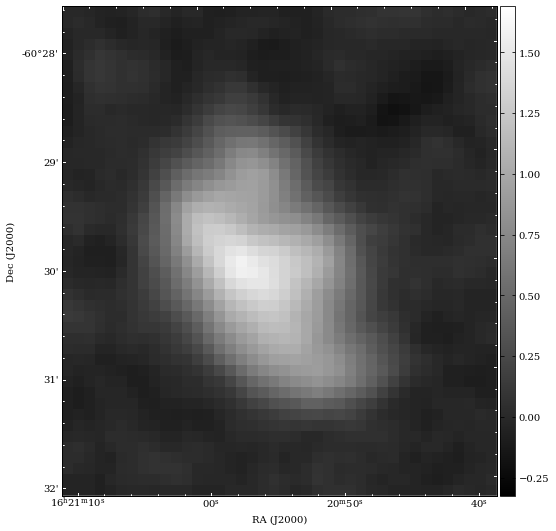

In [61]:
subcube[:,2405:2450,5310:5350].moment0(axis=0).quicklook()
#subcube[:,2400:2460,5300:5360].moment1(axis=0).quicklook()

[ 4.075392    4.5516543   4.381494    4.844865    4.6758633   4.8091507
  4.8844576   4.469826    4.714017    4.6817923   4.216241    5.2395463
  4.855161    5.509885    5.042853    5.5350423   5.481437    5.2469296
  4.285681    3.554109    2.502577    1.7797297   0.69251335  0.284512
 -0.69411546 -0.13359281 -0.31261832 -0.26401284 -0.64300406 -0.5751616
 -0.34446317 -0.76103055 -0.72618014 -0.7365478  -0.17801762 -0.66655254
 -0.68928534 -0.08390445 -0.13220662 -0.19942218 -0.51552045 -0.6745857
 -0.28008497 -0.20665689 -0.56088966 -0.17498317 -0.27488944 -0.58652127
 -0.13313386 -0.43045658 -0.18086874 -0.39303333 -0.04820672 -0.14389804
 -0.45208782 -0.03803302]


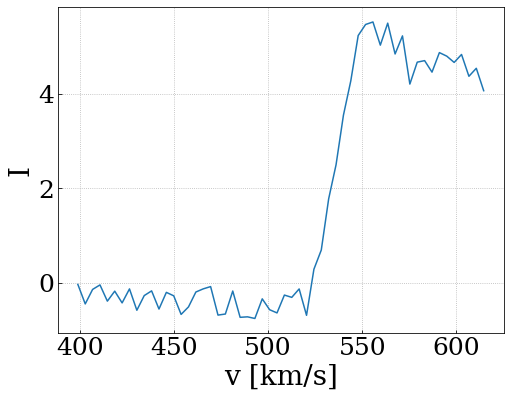

In [70]:
i1 = np.sum(np.array(subcube[:,2405:2450,5310:5350]), axis=1)
i2 = np.sum(i1, axis=1)
print(i2)

restfreq = 1.420405752 * u.GHz  # rest frequency of HI
freq_to_vel = u.doppler_optical(restfreq) # using the radio convention
vel_askap = (subcube.spectral_axis).to(u.km / u.s, equivalencies=freq_to_vel)
    

fig = plt.figure(figsize=(8, 6))
ax1 = fig.add_subplot(111)
ax1.grid(linestyle=':')
plt.plot(vel_askap.value, i2)
plt.ylabel('I', fontsize=28)
plt.xlabel("v [km/s]", fontsize=28)
#plt.legend(fontsize=20)
ax1.tick_params(axis='both', which='major', labelsize=25)
fig.savefig('eso137-018_spectrum.png')

In [23]:
mom_0 = subcube[:,2400:2460,5300:5360].moment0(axis=0)
mom_1 = subcube[:,2400:2460,5300:5360].moment1(axis=0)

hdul = fits.HDUList([mom_0.hdu])
hdul.writeto('eso137-018_mom_0.fits', overwrite=True)
hdul = fits.HDUList([mom_1.hdu])
hdul.writeto('eso137-018_mom_1.fits', overwrite=True)

243.2547291667 -59.00878888889 1.584956
16h13m01.135s -59d00m31.64s


[[<astropy.io.fits.hdu.image.PrimaryHDU object at 0x1c9b544950>]]


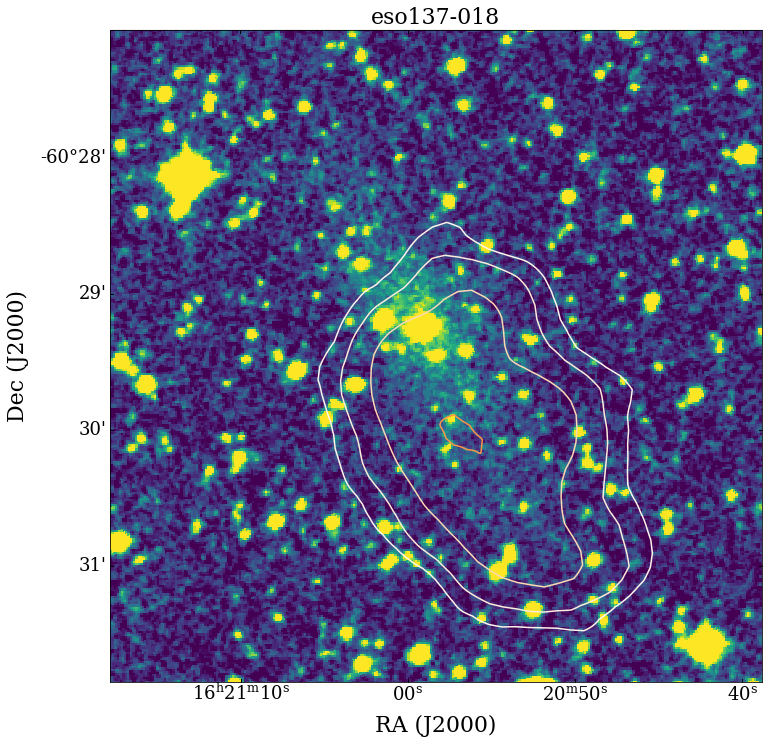

In [33]:
# read in HI data
# find optical image (DSS2 B)
# make the overlay
# note: sometimes there is no sufficently large (0.8 or 0.5 deg) optical image available, in this case the image is skipped

def make_overlay(HI_image, name, view):
    hdulist_hi = fits.open('{}'.format(HI_image))
    d = hdulist_hi[0].data
    h = hdulist_hi[0].header
    d = np.nan_to_num(d)
    rms = np.sqrt(np.mean(np.square(d)))
    print(h['CRVAL1'],h['CRVAL2'], np.max(d))

    #get optical image
    c = SkyCoord(h['CRVAL1'], h['CRVAL2'], unit="deg")
    print(c.to_string('hmsdms'))
    path = SkyView.get_images(position=name, width=view*u.deg, height=view*u.deg, survey=['DSS2 Red'], pixels=[900,900])

    print(path)
    if len(path) !=0:

        hdulist_opt = path[0]
        d2 = hdulist_opt[0].data
        h2 = hdulist_opt[0].header

        #fig = plt.figure(figsize=(18, 12))
        #ax = fig.add_subplot(111)
        #im = ax.imshow(d2, cmap='Oranges')

        #reproject HI data

        hi_reprojected, footprint = reproject_interp(hdulist_hi, h2)
        rms = np.sqrt(np.mean(np.square(hi_reprojected)))

        #plot data together

        fig = plt.figure(figsize=(12, 12))
        ax1 = fig.add_subplot(111, projection=WCS(hdulist_opt[0].header))
        ax1.imshow(d2, cmap='viridis', vmin=np.percentile(d2,10), vmax=np.percentile(d2,96))
        ax1.contour(hi_reprojected, cmap='Oranges', levels=[rms/2, rms, rms*2, rms*4, rms*6, rms*8])
        #ax1.contour(hi_reprojected, cmap='Oranges', levels=5)
        #levs = np.array([0.1, 0.2, 0.4, 0.6, 0.8, 1.0, 1.2])*10**22
        #ax1.contour(hi_reprojected, levels=0, cmap='Blues')
        #ax1.coords.grid(color='white')
        ax1.set_title(name, fontsize=22)
        ax1.tick_params(axis='both', which='major', labelsize=18)
        ax1.coords['ra'].set_axislabel('RA (J2000)', fontsize=22)
        ax1.coords['dec'].set_axislabel('Dec (J2000)', fontsize=22)

        fig.savefig('{}_overlay.png'.format(name), dpi=100)

make_overlay('eso137-018_mom_0.fits', 'eso137-018', 0.08)


23518.138686113005 -55488.68182736179


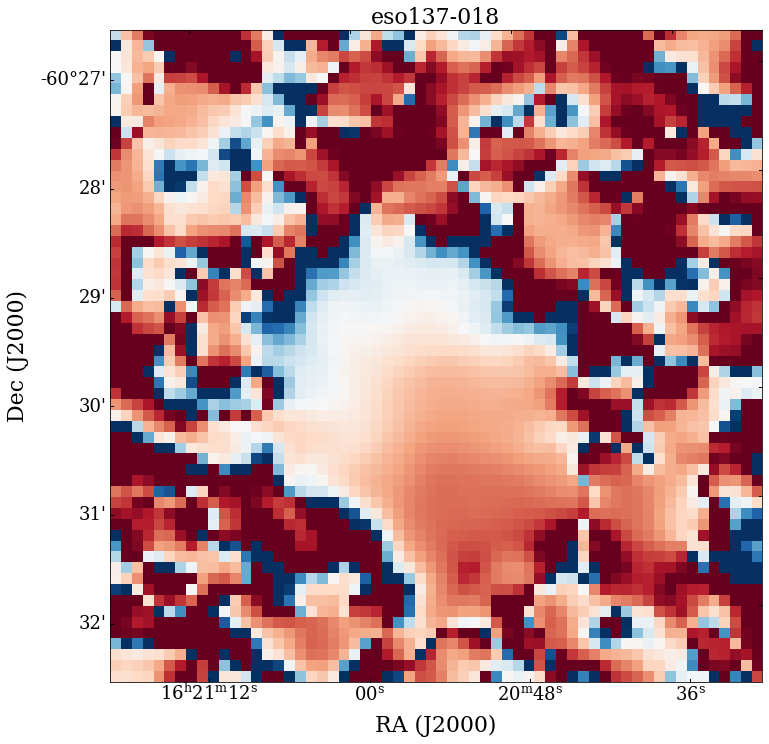

In [46]:
hdulist_hi = fits.open('eso137-018_mom_1.fits')
d = hdulist_hi[0].data
h = hdulist_hi[0].header
d = np.nan_to_num(d)

print(np.max(d), np.min(d))

fig = plt.figure(figsize=(12, 12))
ax1 = fig.add_subplot(111, projection=WCS(h))
ax1.imshow(d, cmap='RdBu', vmin=500, vmax=700)
#ax1.contour(hi_reprojected, cmap='Oranges', levels=[rms/2, rms, rms*2, rms*4, rms*6, rms*8])
#ax1.contour(hi_reprojected, cmap='Oranges', levels=5)
#levs = np.array([0.1, 0.2, 0.4, 0.6, 0.8, 1.0, 1.2])*10**22
#ax1.contour(hi_reprojected, levels=0, cmap='Blues')
#ax1.coords.grid(color='white')
ax1.set_title('eso137-018', fontsize=22)
ax1.tick_params(axis='both', which='major', labelsize=18)
ax1.coords['ra'].set_axislabel('RA (J2000)', fontsize=22)
ax1.coords['dec'].set_axislabel('Dec (J2000)', fontsize=22)

fig.savefig('eso137-018_mom_1.png', dpi=100)

# Hydra

In [133]:
cube = SpectralCube.read('/Users/denes/Research/high_lat_HI/ASKAP_data/data_cubes/Hydra_MW.fits')  # Open the FITS file for reading


In [78]:
cube_2 = cube.with_spectral_unit(u.km/u.s, velocity_convention='optical', rest_value=1.420405752 * u.GHz) 
subcube = cube_2.spectral_slab(250*u.km/u.s,550*u.km/u.s)

INFO: Auto-setting vmin to -1.024e+00 [aplpy.core]
INFO: Auto-setting vmax to  3.978e+00 [aplpy.core]


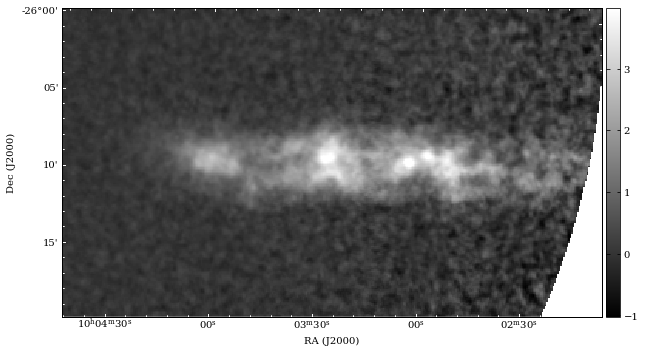

In [96]:
subcube[:,3200:3400,7100:7450].moment0(axis=0).quicklook()


[-12.104258  -13.460443  -12.990476  -13.268799  -15.349594  -11.370466
  -9.143452  -12.301859  -14.932356  -10.640144  -12.354378  -15.163682
 -13.033745  -17.462791  -15.7817745  -9.847578  -11.338147   -6.649097
  -4.57876     9.927748   20.791687   40.675602   89.33958   130.67247
 187.75665   201.98433   205.01247   209.01163   199.64426   211.6822
 216.37115   196.98648   200.82631   194.80836   176.02289   177.3282
 162.80043   150.45412   155.97624   154.21378   165.3317    167.3915
 188.1315    194.44684   197.86792   208.75015   210.64809   213.16284
 216.13899   190.03569   126.02928    94.07316    62.367207   31.0211
   9.417348   -5.3551807  -1.3796086  -7.206538  -15.535743  -15.173324
  -9.870411   -5.3288317 -11.111417  -11.549044   -6.8064475 -13.408688
  -4.075223   -9.500732   -6.092397   -3.7580802  -4.08624   -11.3624115
  -5.6340904  -8.714766   -4.078223  -13.042896  -12.203989   -6.824168 ]


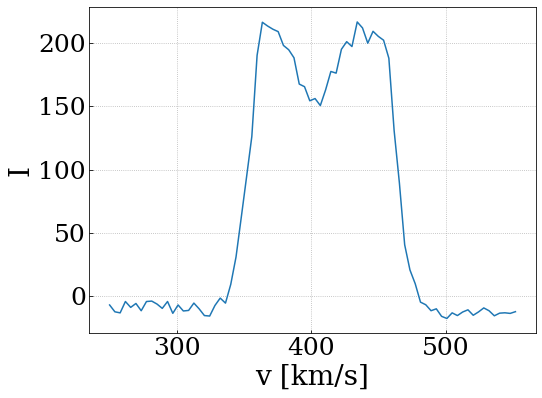

In [84]:
i1 = np.nansum(np.array(subcube[:,3250:3350,7100:7450]), axis=1)
i2 = np.nansum(i1, axis=1)
print(i2)

restfreq = 1.420405752 * u.GHz  # rest frequency of HI
freq_to_vel = u.doppler_optical(restfreq) # using the radio convention
vel_askap = (subcube.spectral_axis).to(u.km / u.s, equivalencies=freq_to_vel)
    

fig = plt.figure(figsize=(8, 6))
ax1 = fig.add_subplot(111)
ax1.grid(linestyle=':')
plt.plot(vel_askap.value, i2)
plt.ylabel('I', fontsize=28)
plt.xlabel("v [km/s]", fontsize=28)
#plt.legend(fontsize=20)
ax1.tick_params(axis='both', which='major', labelsize=25)
fig.savefig('ngc3109_spectrum.png')

In [97]:
mom_0 = subcube[:,3100:3500,7100:7500].moment0(axis=0)
#mom_1 = subcube[:,3200:3400,7100:7500].moment1(axis=0)

hdul = fits.HDUList([mom_0.hdu])
hdul.writeto('ngc3109_mom_0.fits', overwrite=True)

153.9493083333 -27.37438055556 4.738189
10h15m47.834s -27d22m27.77s


[[<astropy.io.fits.hdu.image.PrimaryHDU object at 0x1225509310>]]


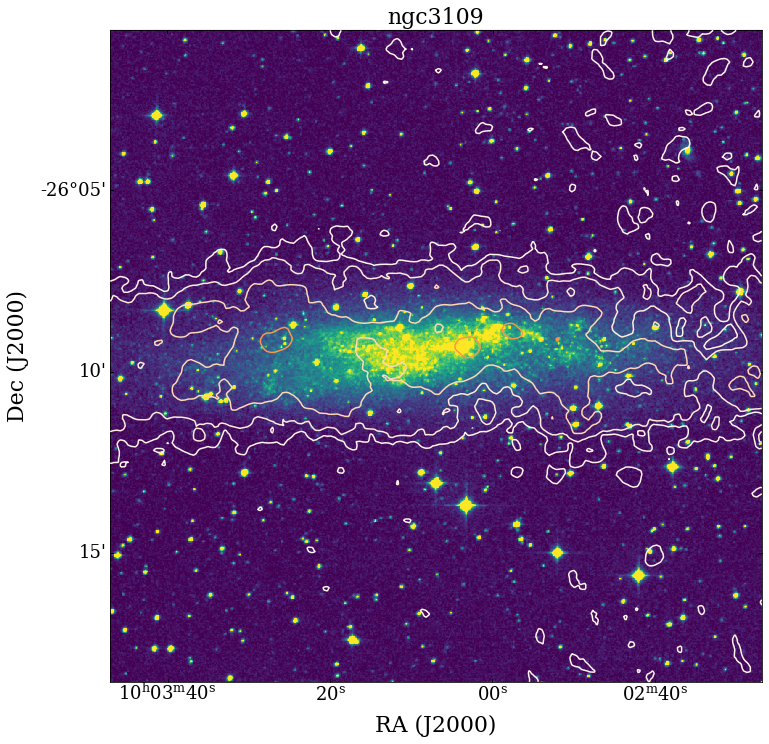

In [104]:
# read in HI data
# find optical image (DSS2 B)
# make the overlay
# note: sometimes there is no sufficently large (0.8 or 0.5 deg) optical image available, in this case the image is skipped

def make_overlay(HI_image, name, view):
    hdulist_hi = fits.open('{}'.format(HI_image))
    d = hdulist_hi[0].data
    h = hdulist_hi[0].header
    d = np.nan_to_num(d)
    rms = np.sqrt(np.mean(np.square(d)))
    print(h['CRVAL1'],h['CRVAL2'], np.max(d))

    #get optical image
    c = SkyCoord(h['CRVAL1'], h['CRVAL2'], unit="deg")
    print(c.to_string('hmsdms'))
    path = SkyView.get_images(position=name, width=view*u.deg, height=view*u.deg, survey=['DSS2 Red'], pixels=[900,900])

    print(path)
    if len(path) !=0:

        hdulist_opt = path[0]
        d2 = hdulist_opt[0].data
        h2 = hdulist_opt[0].header

        #fig = plt.figure(figsize=(18, 12))
        #ax = fig.add_subplot(111)
        #im = ax.imshow(d2, cmap='Oranges')

        #reproject HI data

        hi_reprojected, footprint = reproject_interp(hdulist_hi, h2)
        rms = np.sqrt(np.mean(np.square(hi_reprojected)))

        #plot data together

        fig = plt.figure(figsize=(12, 12))
        ax1 = fig.add_subplot(111, projection=WCS(hdulist_opt[0].header))
        ax1.imshow(d2, cmap='viridis', vmin=np.percentile(d2,10), vmax=np.percentile(d2,99))
        ax1.contour(hi_reprojected, cmap='Oranges', levels=[rms/2, rms, rms*2, rms*4, rms*6, rms*8])
        #ax1.contour(hi_reprojected, cmap='Oranges', levels=5)
        #levs = np.array([0.1, 0.2, 0.4, 0.6, 0.8, 1.0, 1.2])*10**22
        #ax1.contour(hi_reprojected, levels=0, cmap='Blues')
        #ax1.coords.grid(color='white')
        ax1.set_title(name, fontsize=22)
        ax1.tick_params(axis='both', which='major', labelsize=18)
        ax1.coords['ra'].set_axislabel('RA (J2000)', fontsize=22)
        ax1.coords['dec'].set_axislabel('Dec (J2000)', fontsize=22)

        fig.savefig('{}_overlay.png'.format(name), dpi=100)

make_overlay('ngc3109_mom_0.fits', 'ngc3109', 0.30)


4.738189 -1.052325


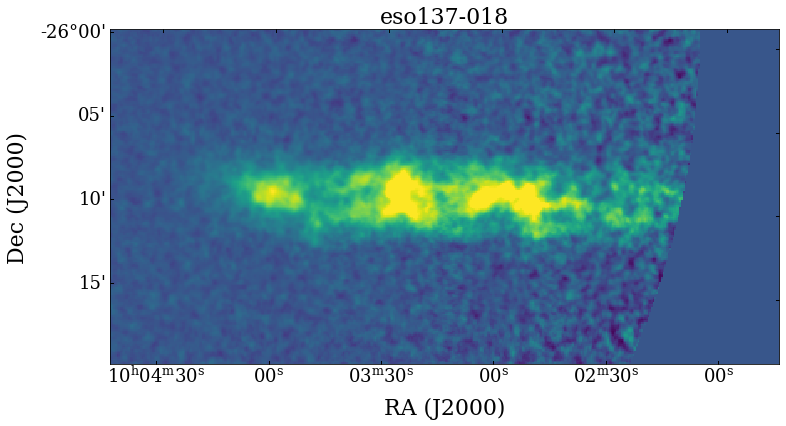

In [94]:
hdulist_hi = fits.open('ngc3109_mom_0.fits')
d = hdulist_hi[0].data
h = hdulist_hi[0].header
d = np.nan_to_num(d)

print(np.max(d), np.min(d))

fig = plt.figure(figsize=(12, 12))
ax1 = fig.add_subplot(111, projection=WCS(h))
ax1.imshow(d, cmap='viridis', vmax=np.percentile(d,99))
#ax1.contour(hi_reprojected, cmap='Oranges', levels=[rms/2, rms, rms*2, rms*4, rms*6, rms*8])
ax1.set_title('eso137-018', fontsize=22)
ax1.tick_params(axis='both', which='major', labelsize=18)
ax1.coords['ra'].set_axislabel('RA (J2000)', fontsize=22)
ax1.coords['dec'].set_axislabel('Dec (J2000)', fontsize=22)

fig.savefig('ngc3109_mom_0.png', dpi=100)

In [134]:
cube = SpectralCube.read('/Users/denes/Research/high_lat_HI/ASKAP_data/data_cubes/NGC4636_MW.fits')  # Open the FITS file for reading


In [154]:
cube_2 = cube.with_spectral_unit(u.km/u.s, velocity_convention='optical', rest_value=1.420405752 * u.GHz) 
#subcube = cube_2.spectral_slab(-10*u.km/u.s,250*u.km/u.s)
subcube = cube_2.spectral_slab(400*u.km/u.s,660*u.km/u.s)

INFO: Auto-setting vmin to -3.145e-01 [aplpy.core]
INFO: Auto-setting vmax to  9.556e-01 [aplpy.core]


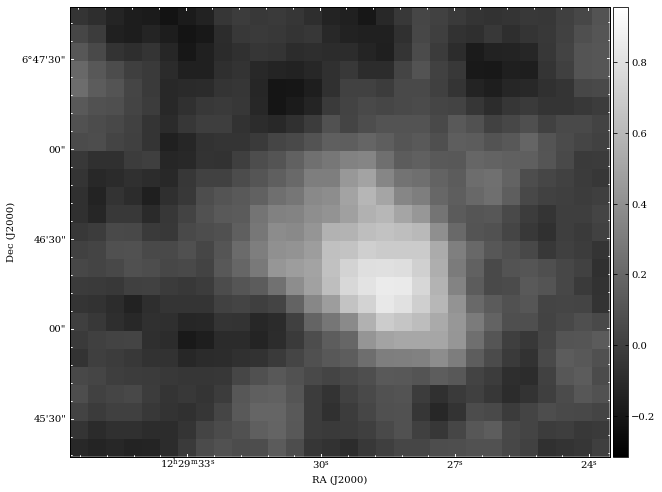

In [155]:
#subcube[:,6870:6910,2420:2450].moment0(axis=0).quicklook()
subcube[:,6680:6705,3650:3680].moment0(axis=0).quicklook()

    

[-0.29190916 -0.39273146  0.19958259 -0.3015512   0.13774362 -0.25837836
  0.07409716  0.38181266 -0.238689    0.423805    0.14701635  0.4074584
  0.13083667  0.652973    0.73089796  0.41084012 -0.3113528   0.61253977
  0.6796673   0.12813032  1.004951    1.0950158   1.0538507   0.60576737
  0.7400837   0.68335396  0.74229354  1.2963074   1.3884234   0.7374308
  0.90276283  1.331698    0.39699295  1.2295331   0.05305355 -0.07934599
  0.83569133 -0.31489056 -0.3450413  -0.2952308  -0.36867777 -0.5502262
  0.2363145  -0.14045912  0.00177925 -0.30539817 -0.23321399  0.47626576
  0.37734395  0.41851458 -0.36380544 -0.47689152 -0.09831529 -0.3590384
 -0.48268795 -0.1820839  -0.41837072  0.17483683 -0.07251587  0.14936665
 -0.60265857 -0.10383244 -0.45599464 -0.2587826   0.12397309 -0.51350707
 -0.22697654 -0.2802973  -0.06479536  0.08698446 -0.18401293  0.5568454
 -0.35779145 -0.24904336 -0.4278118   0.23504552  0.05843414  0.08535702
 -0.58349216  0.1283209   0.42168882]


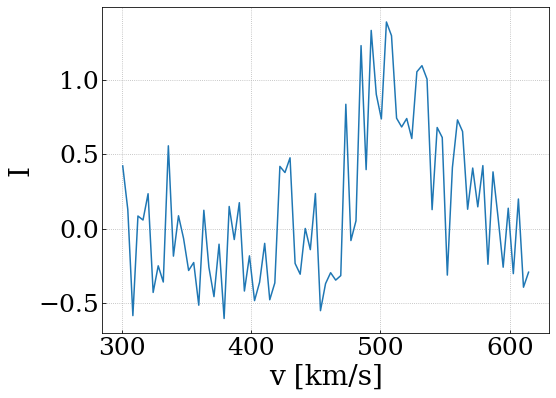

In [150]:
i1 = np.nansum(np.array(subcube[:,6680:6705,3650:3680]), axis=1)
i2 = np.nansum(i1, axis=1)
print(i2)

restfreq = 1.420405752 * u.GHz  # rest frequency of HI
freq_to_vel = u.doppler_optical(restfreq) # using the radio convention
vel_askap = (subcube.spectral_axis).to(u.km / u.s, equivalencies=freq_to_vel)
    

fig = plt.figure(figsize=(8, 6))
ax1 = fig.add_subplot(111)
ax1.grid(linestyle=':')
plt.plot(vel_askap.value, i2)
plt.ylabel('I', fontsize=28)
plt.xlabel("v [km/s]", fontsize=28)
#plt.legend(fontsize=20)
ax1.tick_params(axis='both', which='major', labelsize=25)
fig.savefig('ic3414_spectrum.png')

In [156]:
#mom_0 = subcube[:,6860:6930,2400:2470].moment0(axis=0)
mom_0 = subcube[:,6650:6730,3630:3700].moment0(axis=0)


hdul = fits.HDUList([mom_0.hdu])
#hdul.writeto('pgc42169_mom_0.fits', overwrite=True)
hdul.writeto('ic3414_mom_0.fits', overwrite=True)

189.0593916667 5.399461111111 0.85430473
12h36m14.254s +05d23m58.06s


[[<astropy.io.fits.hdu.image.PrimaryHDU object at 0x12262e2790>]]


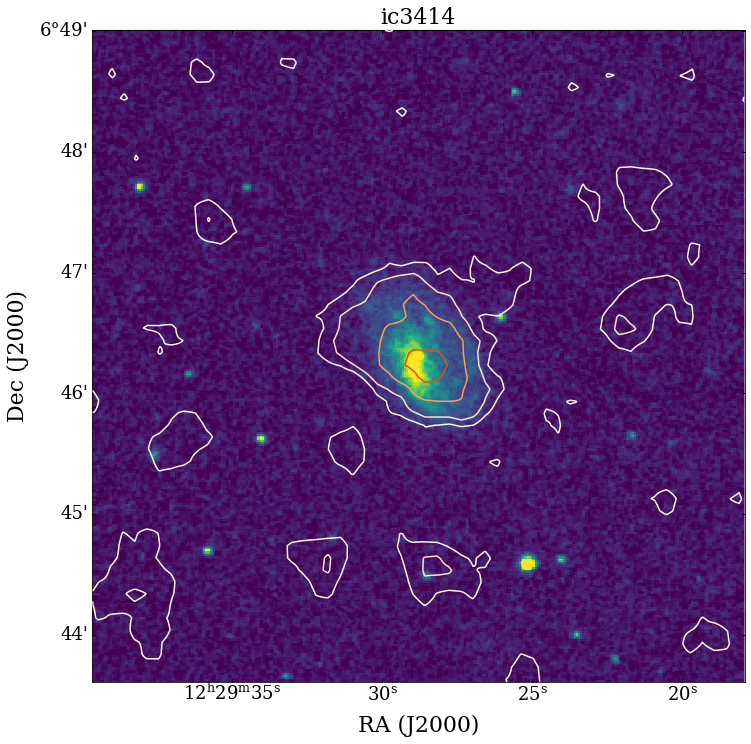

In [159]:
# read in HI data
# find optical image (DSS2 B)
# make the overlay
# note: sometimes there is no sufficently large (0.8 or 0.5 deg) optical image available, in this case the image is skipped

def make_overlay(HI_image, name, view):
    hdulist_hi = fits.open('{}'.format(HI_image))
    d = hdulist_hi[0].data
    h = hdulist_hi[0].header
    d = np.nan_to_num(d)
    rms = np.sqrt(np.mean(np.square(d)))
    print(h['CRVAL1'],h['CRVAL2'], np.max(d))

    #get optical image
    c = SkyCoord(h['CRVAL1'], h['CRVAL2'], unit="deg")
    print(c.to_string('hmsdms'))
    path = SkyView.get_images(position=name, width=view*u.deg, height=view*u.deg, survey=['DSS2 Red'], pixels=[900,900])

    print(path)
    if len(path) !=0:

        hdulist_opt = path[0]
        d2 = hdulist_opt[0].data
        h2 = hdulist_opt[0].header

        #fig = plt.figure(figsize=(18, 12))
        #ax = fig.add_subplot(111)
        #im = ax.imshow(d2, cmap='Oranges')

        #reproject HI data

        hi_reprojected, footprint = reproject_interp(hdulist_hi, h2)
        rms = np.sqrt(np.mean(np.square(hi_reprojected)))

        #plot data together

        fig = plt.figure(figsize=(12, 12))
        ax1 = fig.add_subplot(111, projection=WCS(hdulist_opt[0].header))
        ax1.imshow(d2, cmap='viridis', vmin=np.percentile(d2,10), vmax=np.percentile(d2,99.9))
        ax1.contour(hi_reprojected, cmap='Oranges', levels=[rms, rms*2, rms*4, rms*6, rms*8])
        #ax1.contour(hi_reprojected, cmap='Oranges', levels=5)
        #levs = np.array([0.1, 0.2, 0.4, 0.6, 0.8, 1.0, 1.2])*10**22
        #ax1.contour(hi_reprojected, levels=0, cmap='Blues')
        #ax1.coords.grid(color='white')
        ax1.set_title(name, fontsize=22)
        ax1.tick_params(axis='both', which='major', labelsize=18)
        ax1.coords['ra'].set_axislabel('RA (J2000)', fontsize=22)
        ax1.coords['dec'].set_axislabel('Dec (J2000)', fontsize=22)

        fig.savefig('{}_overlay.png'.format(name), dpi=100)

make_overlay('ic3414_mom_0.fits', 'ic3414', 0.09)
